In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [45]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [46]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [47]:
C = torch.randn((27,2))

In [48]:
C[torch.tensor([1,2,3])]

tensor([[ 0.6281,  0.0380],
        [ 0.0225,  0.0967],
        [ 0.4034, -0.0411]])

In [49]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([1.1492, 1.9260])

In [50]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [51]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [34]:
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
h

tensor([[-0.9993, -0.9103,  0.8720,  ...,  0.3850, -0.9926, -0.8552],
        [-0.9974, -0.9579,  0.9102,  ...,  0.8081, -0.9978, -0.9118],
        [-1.0000,  0.9392,  0.8382,  ..., -0.8477,  0.4483, -0.6210],
        ...,
        [ 0.9999, -0.7733, -0.1906,  ...,  0.9992, -0.5336,  0.0981],
        [-0.9782,  0.9965, -0.9219,  ..., -0.9982,  0.9969,  0.9994],
        [ 0.8783,  0.8927,  0.9871,  ...,  0.9998, -0.4735, -0.9681]])

In [35]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [37]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [40]:
# probs = F.softmax(logits, dim=1)
counts = logits.exp()
probs = counts / counts.sum()
probs.shape

torch.Size([32, 27])

In [41]:
# Optimized version
X.shape, Y   # dataset

(torch.Size([32, 3]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [61]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [62]:
sum(p.numel() for p in parameters)

3481

In [78]:
for _ in range(100):

    # minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.989506959915161


In [102]:
# Understanding optimal learning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [103]:
lri = []
lossi = []

In [104]:
for i in range(1000):

    # minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    # lri.append(lri)
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

4.283209323883057


In [105]:
emb = C[X]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

4.253878593444824

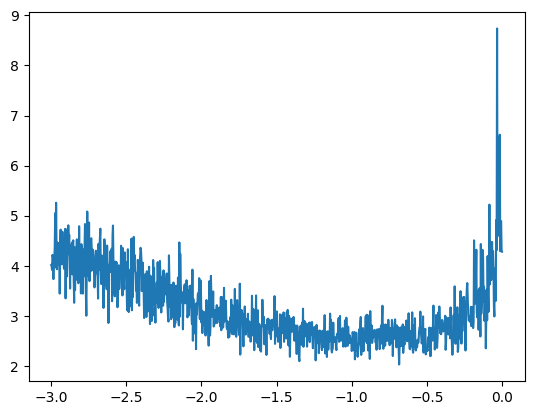

In [106]:
plt.plot(lri, lossi)

In [107]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [108]:
Xtr.shape, Ytr.shape # dataset


(torch.Size([182625, 3]), torch.Size([182625]))

In [110]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [111]:
sum(p.nelement() for p in parameters) # number of parameters in total


11897

In [112]:
for p in parameters:
  p.requires_grad = True

In [113]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [114]:
lri = []
lossi = []
stepi = []

In [115]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

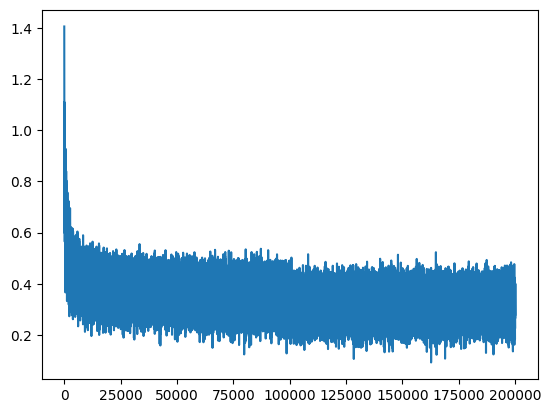

In [119]:
plt.plot(stepi, lossi)

In [120]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1182, grad_fn=<NllLossBackward0>)

In [121]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1602, grad_fn=<NllLossBackward0>)

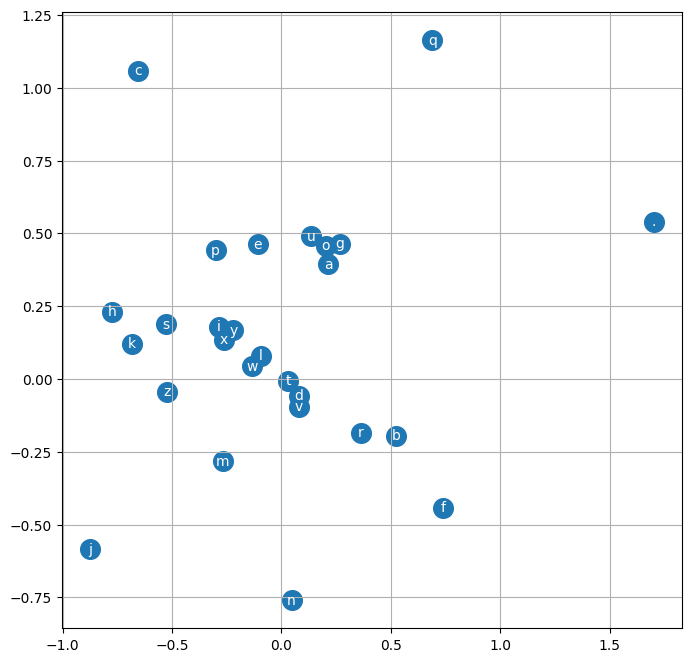

In [122]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [123]:
# Testing
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [124]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amille.
khirmiliathty.
halaysleja.
huth.
ameryncia.
quic.
ramara.
chaihy.
kaleigh.
ham.
pris.
quint.
shous.
alian.
quisaelo.
dearysia.
kaeliigsan.
edde.
iia.
